### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Data analysis

In [3]:
dataset = pd.read_json('../data/dataset_2weeks.jsonl', lines=True)
dataset = dataset[dataset.type.eq('edit')].reset_index(drop=True)

We decided to filter out edits only, since it's actuall change requests for specific title, 
without any meta-data such as user logins, etc.

#### How many datapoints do we have?

In [4]:
len(dataset)

431537

In [5]:
dataset.timestamp.max() - dataset.timestamp.min()

Timedelta('13 days 08:26:45')

We have collected 430k datapoints for almost two weeks of 20% sampled data stream

### What is the distribution of users by bot tag?

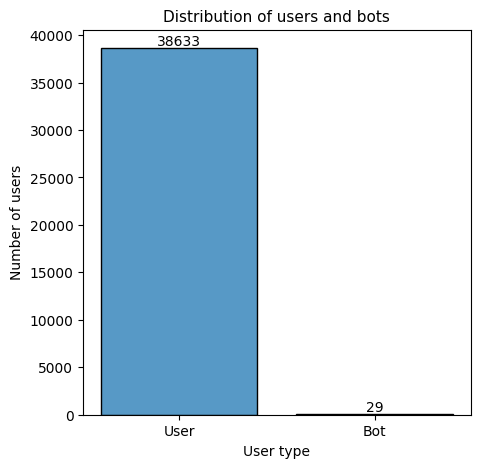

In [6]:
ax = sns.histplot(data=dataset.groupby('user')['bot'].max(), discrete=True, shrink=0.8)
ax.bar_label(ax.containers[0], fmt='%i', label_type='edge')
plt.title('Distribution of users and bots', fontsize=11)
plt.xlabel('User type')
plt.ylabel('Number of users')
plt.xticks([0, 1], ['User', 'Bot'])

fig = plt.gcf()
fig.set_size_inches(5, 5)

Very significant class imbalance! Pretty interesting to work on the model for such a distribution

#### What is distribution of changes made by users, bots and no bots

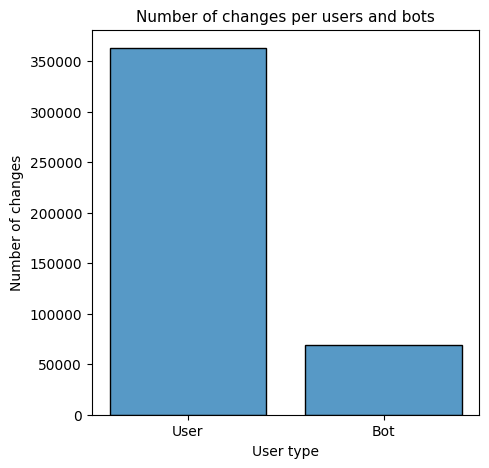

In [7]:
sns.histplot(data=dataset, x='bot', discrete=True, shrink=0.8)
plt.title('Number of changes per users and bots', fontsize=11)
plt.xlabel('User type')
plt.ylabel('Number of changes')
plt.xticks([0, 1], ['User', 'Bot'])

fig = plt.gcf()
fig.set_size_inches(5, 5)

It's clear that bots produce much more messages, compared to the users

#### When the edits were made

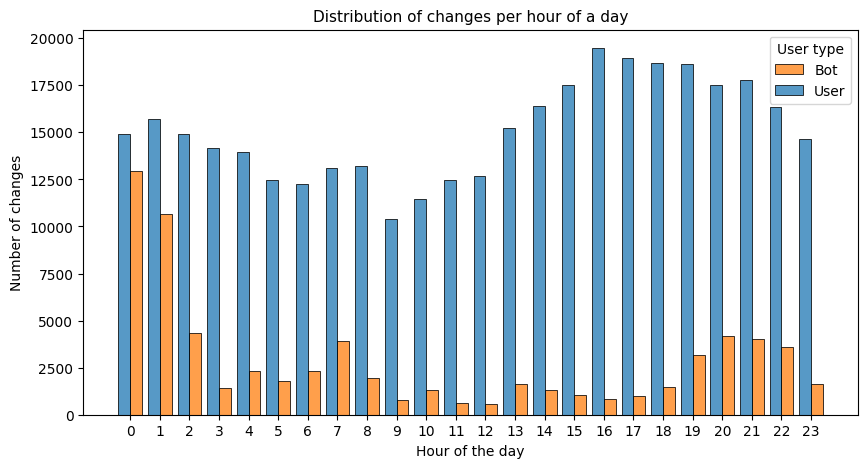

In [8]:
dataset['day'] = dataset.timestamp.dt.day
dataset['hour'] = dataset.timestamp.dt.hour

sns.histplot(x='hour', hue='bot', data=dataset, multiple='dodge', discrete=True, shrink=0.8)
plt.xlabel('Hour of the day')
plt.ylabel('Number of changes')
plt.legend(['Bot', 'User'], title='User type')
plt.xticks(np.arange(0, 24))
plt.title('Distribution of changes per hour of a day', fontsize=11)

fig = plt.gcf()
fig.set_size_inches(10, 5)

Bots most active at midnight, but got suspended closer to midday.
Users peak activity at 4 pm.

### How fast changes are made

In [9]:
dataset['timestamp_s'] = dataset['timestamp'].astype('datetime64[s]').astype(int)

dataset = dataset.sort_values(by=['user', 'timestamp_s'])
dataset['time_delta'] = dataset.groupby('user').timestamp_s.diff()
user_time_delta_data = dataset.dropna(subset=['time_delta'])

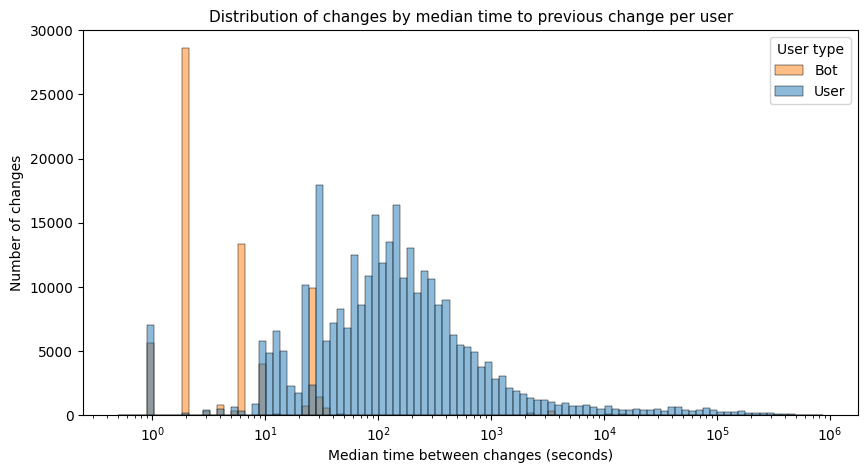

In [10]:
users_time_delta = pd.merge(
    user_time_delta_data.groupby('user')['time_delta'].median(),
    user_time_delta_data.set_index('user')['bot'],
    left_index=True,
    right_index=True
)
users_time_delta['time_delta'] = users_time_delta['time_delta']
users_time_delta['bot'] = users_time_delta['bot'].apply(lambda x: 'Bot' if x else 'User')
users_time_delta.loc[users_time_delta['time_delta'] > 864000, 'time_delta'] = 864000

ax = sns.histplot(data=users_time_delta, x='time_delta', hue='bot', bins=100, log_scale=True)

plt.title('Distribution of changes by median time to previous change per user', fontsize=11)
plt.ylabel('Number of changes')
plt.xlabel('Median time between changes (seconds)')
plt.legend(['Bot', 'User'], title='User type')

fig = plt.gcf()
fig.set_size_inches(10, 5);

This plot show's distribution of the time between two sequentual changes per user.
It's important to notice that users with single change for whole period, was excluded.

We can notice that bots were scheduled for some specific time, the spikes are 1, 5, 10, and 20 seconds.
But users changes time difference is normally distributed, and is about 100 seconds between changes.

In [54]:
bot_series = dataset.groupby('user')['bot'].max()
users_time_delta = user_time_delta_data.groupby('user')['time_delta'].median()
users_time_delta = pd.merge(users_time_delta, bot_series, left_index=True, right_index=True)
users_time_delta['time_delta'].dropna(inplace=True)
users_time_delta['time_delta'] = users_time_delta['time_delta'].astype('timedelta64[s]').astype(int)

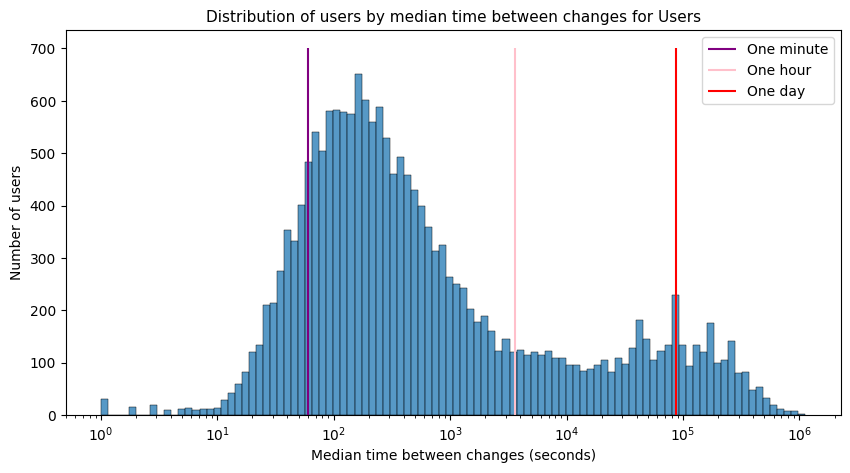

In [55]:
users_time_delta_user = users_time_delta[users_time_delta['bot'] == False]

sns.histplot(data=users_time_delta_user, x='time_delta', bins=100, log_scale=True)
plt.title('Distribution of users by median time between changes for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Median time between changes (seconds)')

plt.vlines(60, 0, 700, color='purple', label='One minute')
plt.vlines(3600, 0, 700, color='pink', label='One hour')
plt.vlines(86400, 0, 700, color='red', label='One day')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

We can see that most of the users makes changes in several minutes. 
There also significant tail in one day difference.

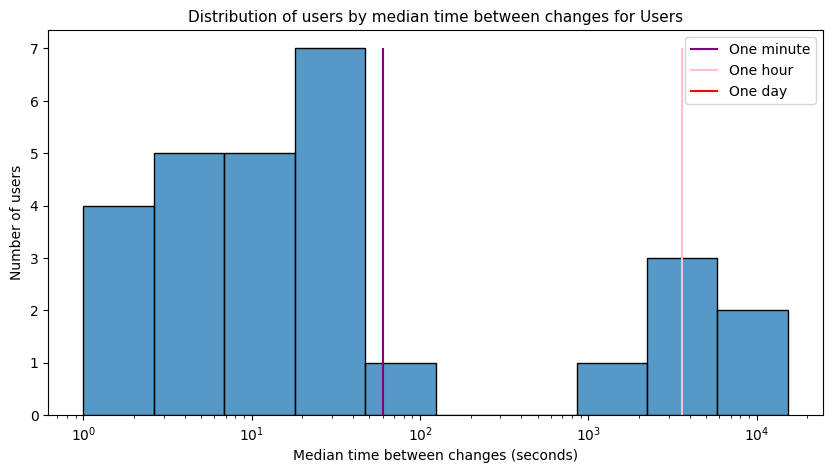

In [58]:
users_time_delta_bot = users_time_delta[users_time_delta['bot'] == True]

sns.histplot(data=users_time_delta_bot, x='time_delta', bins=10, log_scale=True)
plt.title('Distribution of users by median time between changes for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Median time between changes (seconds)')

plt.vlines(60, 0, 7, color='purple', label='One minute')
plt.vlines(3600, 0, 7, color='pink', label='One hour')
plt.vlines(86400, 0, 7, color='red', label='One day')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

The bots are way frequent than users. The slowest ones can perform changes once per hour. 
Usually they does their changes whithin one minute.

In [30]:
users_total_count = user_time_delta_data.groupby('user')['title'].count()
users_total_count = pd.merge(users_total_count, bot_series, left_index=True, right_index=True)

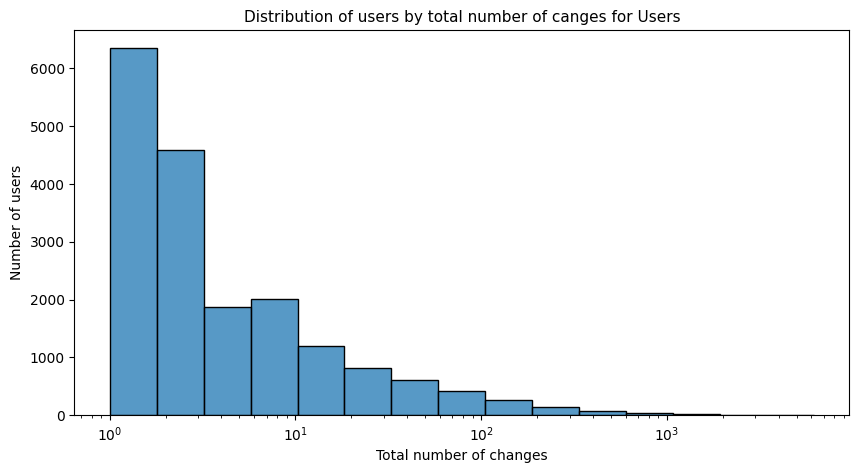

In [45]:
users_total_count_user = users_total_count[users_total_count['bot'] == False]
# users_total_count_user[users_total_count_user['title'] > 1000] = 1000
sns.histplot(data=users_total_count_user, x='title', bins=15, log_scale=True)
plt.title('Distribution of users by total number of canges for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Total number of changes')

fig = plt.gcf()
fig.set_size_inches(10, 5)

We can see that most of the users created only one change. There is pretty long tail, while the most active ones created thousand of changes in two weeks.

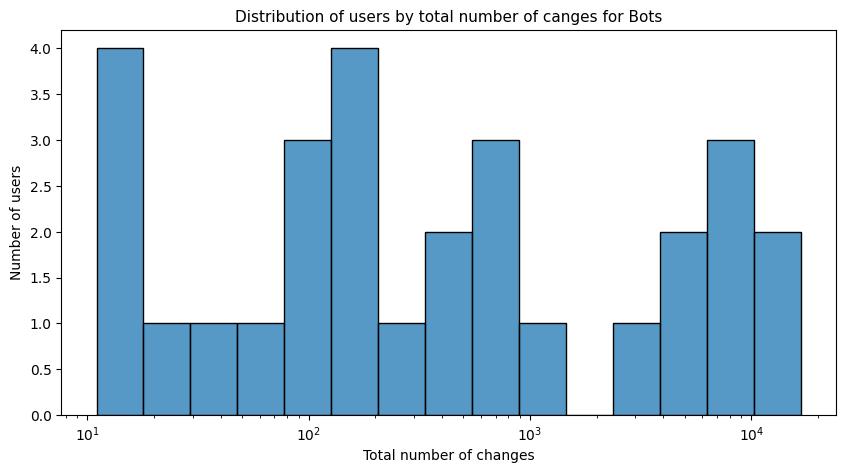

In [48]:
users_total_count_bot = users_total_count[users_total_count['bot'] == True]

sns.histplot(data=users_total_count_bot, x='title', bins=15, log_scale=True)
plt.title('Distribution of users by total number of canges for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Total number of changes')

fig = plt.gcf()
fig.set_size_inches(10, 5)

Bots way active compared to the users. The smallest number of changes for bot is 10! The most active bots can perform thousands of changes.

In [18]:
changes_per_day = dataset.groupby(['user', 'day']).day.count().groupby('user').median()
changes_per_day = pd.merge(changes_per_day, bot_series, left_index=True, right_index=True)

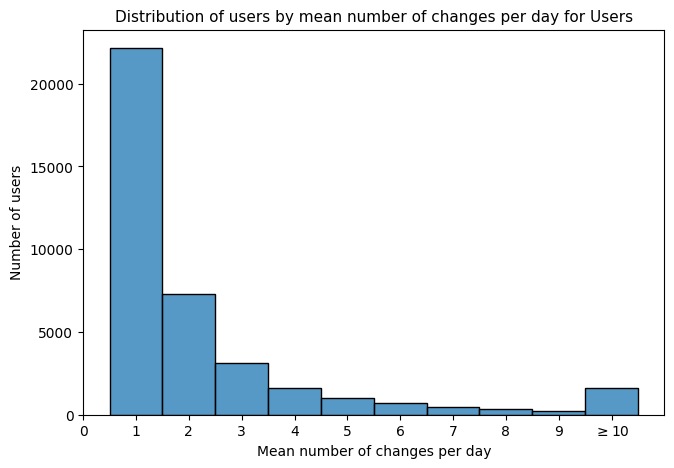

In [19]:
changes_per_day_user = changes_per_day[changes_per_day['bot'] == False]

changes_per_day_user.loc[changes_per_day_user['day'] > 10, 'day'] = 10
ax = sns.histplot(data=changes_per_day_user, x='day', bins=10, discrete=True)
plt.title('Distribution of users by mean number of changes per day for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per day')
plt.xticks(np.arange(0, 11))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[-1] = '$\geq10$'
ax.set_xticklabels(xlabels);

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

We can see that most of the users does only one change per day.
There was only days where changes being made included

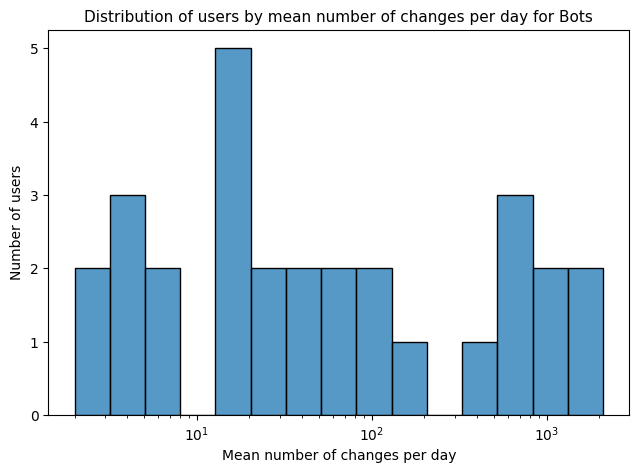

In [177]:
changes_per_day_bot = changes_per_day[changes_per_day['bot'] == True]

ax = sns.histplot(data=changes_per_day_bot, x='day', bins=15, log_scale=True)
plt.title('Distribution of users by mean number of changes per day for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per day')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

There are different bots, some of them does up to ten changes in single day, but there are bots that does thousands of changes.

In [20]:
changes_per_hour = dataset.groupby(['user', 'day', 'hour']).hour.count().groupby('user').mean()
changes_per_hour = pd.merge(changes_per_hour, bot_series, left_index=True, right_index=True)

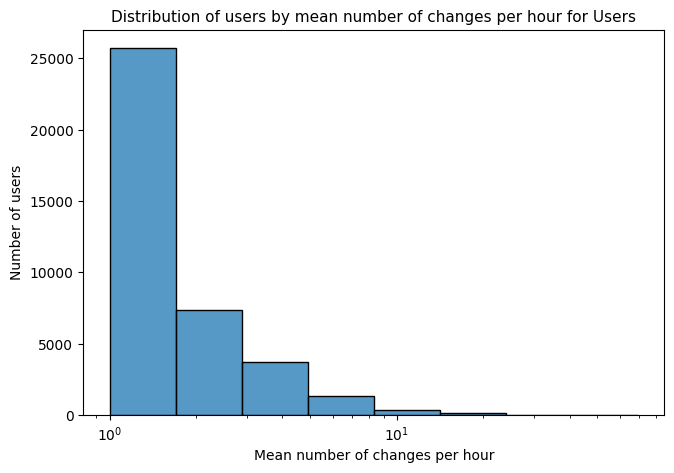

In [21]:
changes_per_hour_user = changes_per_hour[changes_per_hour['bot'] == False]

ax = sns.histplot(data=changes_per_hour_user, x='hour', bins=8, log_scale=True)
plt.title('Distribution of users by mean number of changes per hour for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per hour')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

Users can perform up to 10 changes in single hour

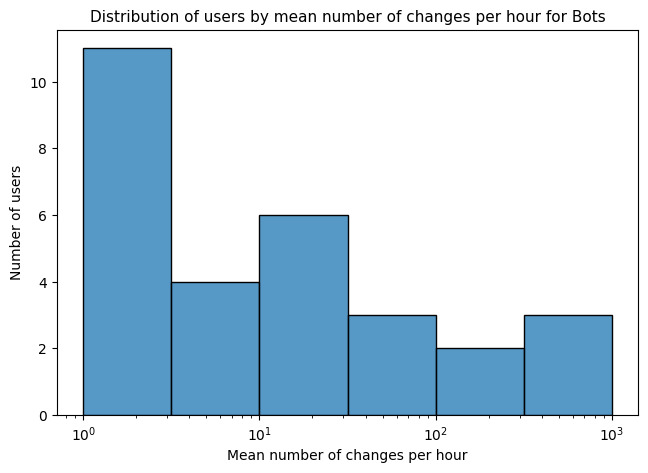

In [130]:
changes_per_hour_bot = changes_per_hour[changes_per_hour['bot'] == True]
changes_per_hour_bot.loc[changes_per_hour_bot['hour'] > 1000, 'hour'] = 1000
ax = sns.histplot(data=changes_per_hour_bot, x='hour', log_scale=True)
plt.title('Distribution of users by mean number of changes per hour for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per hour')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

Bots way active, they can peform even thousand changes in single hour.